# Conditional Variational Autoencoder (CVAE)

**Author**: Benjamin Urben<br>
**Email**: burben@student.ethz.ch / benjamin.urben@hotmail.ch<br>
**Context**: Master Thesis on "Use of Conditional Variational Autoencoder (cVAE) in the design of connections"<br>
**Institution**: ETH Zürich, Institute of Structural Engineering (IBK)

**Description**:

Implementation of a Conditional Variational Autoencoder (CVAE) including data preparation, training and evaluation.

**Dependencies**: 
- `CVAE.py`
- `DNN.py`
- `Datareader.py`
- `Settings.py`
- `Plot_Functions.py`
- `Saved Models\DNN_Model_Full_V2\DNN_Model_Full_V2.pth`

**Generates**:
- `Saved Models\CVAE_Model_Test\CVAE_Model_Test.pth`

## Setup

### Import

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import copy
import os
import pickle

import importlib

from DataReader import DataReader
from Settings import Directory, Plotting_Parameters
from DNN import DNN
from CVAE import CVAE
from Plot_Functions import plot_MV_interaction

import warnings
warnings.filterwarnings('ignore')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


In [2]:
plot_params = Plotting_Parameters()
directory = Directory()

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks


### Load Data

In [3]:
datareader = DataReader()
df_full = datareader.load('Knee_Connection_Output_red.csv')

Root Directory set to:  c:\Users\benja\OneDrive\Desktop\Masterarbeit\Code\10_Neural_Networks
df_full_filtered.csv
Extended_Database.csv
Extended_Database_filtered_converted.csv
Extended_Database_FilterOn.csv
Extended_Database_test.csv
extended_profiles_filteron_iter_1.csv
extended_profiles_iter_1.csv
extended_profiles_iter_2.csv
extended_profiles_iter_3.csv
GAL_Generated_Data.csv
Knee_Connection_Output_red.csv
Knee_parallel_I_Off0_Output_red_Q1.xlsx
Knee_parallel_I_Off0_Output_red_Q4.xlsx
Knee_parallel_I_Output_Q1.xlsx
Knee_parallel_I_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Off0_Output_red_Q4.xlsx
Knee_perpendicular_n.stiff_Output_red_Q1.xlsx
Knee_perpendicular_n.stiff_Output_red_Q4.xlsx
Knee_widener_I_Output_Off0_red_Q1.xlsx
Knee_widener_I_Output_red_Q1.xlsx
_OLD
Knee_Connection_Output_red.csv: (714385, 53)


### Load Forward Model

In [4]:
model_name = 'DNN_Model_Full_V3'
MODEL_FORWARD_SAVE_FILE = rf"Saved Models\{model_name}\{model_name}.pth"

model_forward = DNN()
model_forward = torch.load(MODEL_FORWARD_SAVE_FILE)

for key, value in model_forward.config.items():
    print(key, value)

batch_size 256
epochs 2500
learning_rate 0.001
test_size 0.1
val_size 0.1
print_logs True
dropout_prob 0.0
num_layers 3
neurons_per_layer [128, 64, 32, 16, 8]
use_batch_norm True
seed 42
description Different to V2, do not Cat_h & Cath_stiffc features


## Create Model

### Loss Theory

Use beta-VAE approach:

$$\mathcal{L}_{β-VAE} = \text{Reconstruction Loss} + β * KL_{Loss}$$

- When β = 1, you have the standard VAE
- When β < 1, you prioritize reconstruction quality over latent space regularization
- When β > 1, you enforce stronger regularization on the latent space, often leading to more disentangled representations

Typical values:

- For better reconstruction: β = 0.1 to 0.5
- For disentanglement: β = 4 to 10
- Common starting point: β = 0.5 to 1

$KL≈ 0$: Your encoder output almost constant $\mu≈0, \log{\sigma^2}≈0, q(x|z,x)≈\mathcal{N}(0,\text{I})$

- Bad for generation - decoder ignores $z$, only sees conditioning input

- Deterministic output regardless of $z$ and $c$

- Model behaves like an autoencoder with no latent variabilty

KL too high: Model over-redularizes, forcing latent vectors to be too close to zero, potentially hurting reconstruction


Reasons for high **Reconstruction Loss**:

- Insufficient model capacity - Your encoder/decoder architecture may be too small or shallow to capture the complexity of your data
- Underfitting - The model hasn't trained long enough to learn good reconstructions
- Inappropriate latent space dimension - If your latent space is too small, it might not capture enough information
- Poor conditioning - The conditional information might not be properly integrated into the network
- Data complexity - Your data might be inherently difficult to reconstruct, especially if it contains high-frequency details

Reasons for high **KL Divergence Loss**:

- Posterior collapse - The model is ignoring the latent variables and solely relying on the decoder and conditional information
- Too much regularization - If your KL weight (β) is too high, forcing the latent distribution too strongly toward the prior
- Poor latent space organization - The model hasn't learned a smooth, well-organized latent space
- Capacity issues - The model might be struggling to balance reconstruction quality with distributional constraints

#### Reconstruction Loss

$$\mathcal{L}_{\text{recon}} = \frac{1}{N} \sum_{i=1}^{N} \| x_i - \hat{x}_i \|^2$$

This term measures the mean squared error (MSE) between the input data $x$ and its reconstruction $\hat{x}$.  It assumes that the data likelihood 
$p_\theta(x|z)$ follows a Gaussian distribution with unit variance, leading to the MSE as the negative log-likelihood.

In Conditional VAEs, the reconstruction loss evaluates how well the model can reconstruct the input x given both the latent variable z and the condition 

#### Kullback-Leibler (KL) Divergence

$$\mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum_{j=1}^{d} \left( 1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2 \right)$$

This term computes the KL divergence between the approximate posterior $q_\phi(z|x,y)$ modeled as $\mathcal{N}(\mu, \sigma^2)$, and the prior $p(z) = \mathcal{N}(0, I)$. It quantifies how much the learned distribution deviates from the prior.

If $KL_\text{Loss}$ reduces to 0: **Posterior collapse**

#### Total Loss

If $\beta$ is small, the model focuses more on minimizing the reconstruction loss, potentially ignoring the KL loss.

If $\beta$ is large, the model focuses on minimizing KL loss, leading to a more regularized latent space but potentially worse reconstruction.

$$\frac{\mathcal{L}_{\text{KL}}}{\mathcal{L}_{\text{recon}}} \approx \text{desired\_ratio}$$

$$\text{direction} = \frac{\text{desired\_ratio} \times \mathcal{L}_{\text{recon}}}{\mathcal{L}_{\text{KL}}}$$


$$\text{kl\_reconstruction\_ratio} = \frac{\beta \mathcal{L}_{KL,val}}{\mathcal{L}_{Recon,val}}$$

$$\text{direction} = \frac{\text{kl\_reconstruction\_ratio\_target}}{\text{kl\_reconstruction\_ratio}}$$

$$\frac{1}{\text{learning rate}}<\text{direction}<\text{learning rate}$$

$$\beta_{\text{new}} = \beta_{\text{old}} \cdot \text{direction} $$


$$\text{kl\_reconstruction\_ratio} = \frac{\beta \times \text{val\_kl\_loss}}{\text{val\_recon\_loss}}$$


### RL and KL Mean or Sum approach


#### Mean 

reconstruction_loss = F.mse_loss(x_reconstruction, x_batch, reduction='mean')
kl_loss = -0.5 * torch.mean(1 + z_log_var - z_mean.pow(2) - torch.exp(z_log_var))

#### Sum

reconstruction_loss = F.mse_loss(x_reconstruction, x_batch, reduction='sum')
kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - torch.exp(z_log_var))

## Regularization

IML are often ill-posed problems (Haradam). A technique often used to prevent Ill-Posedness is regularization. One of the most prominent techniques used is the Tikhonov Regularization. (Also known as the L2 regularization).
Tikhonov regularization (also known as L2 regularization) adds a penalty term to the loss to discourage large weights or large parameter estimates:

$$\text{Loss} = \text{Reconstruction Loss} + \text{KL Divergence} + \lambda \|\mathbf{W}\|^2$$

In IML/CVAE contexts, Tikhonov can be applied to:

- Latent variables (encouraging smooth inverse mappings),

- Weights of decoder or encoder (model regularization),

- Or the estimated inverse parameters (if you're recovering inputs).

If you're using CVAE to invert outputs to infer inputs, Tikhonov helps ensure inferred latent/inverse representations don’t overfit noise.
It also makes the inverse mapping more stable, improving generalization — a direct mitigation of ill-posedness.


$\text{KL}_{Loss} = -\frac{1}{2N} \sum{(1+\log(\hat{z})-z_\mu^2-e^{\hat{z}})}$

### Define Features and Conditions

In [5]:
conditions = ["h_x", "b_x", "tw_x", "tf_x", "fy_x",
              "h_y", "b_y", "tw_y", "tf_y", "fy_y",
              "Offset", "Gamma", "V_norm", "M_norm",
              "d_wid", "t_fwid", "t_wwid"]

features = ["t_stiffc", "h_wid", "b_wid"]

### Build Model

In [6]:
model = CVAE(features, conditions)

Description: No dynamic beta adjustment
Outcome: Irresversible posterior collapse

In [ ]:
model.config['epochs'] = 500
model.config['beta'] = 1.0
model.config['loss_balance_target'] = 1.0
model.config['latent_dim'] = 8
model.config['loss_balance_lr'] = 1.0
model.config['learning_rate'] = 0.0001
model.config['patience'] = 20
model.config['freeze_copy_every_n_epochs'] = 10
model.config['L2_factor'] = 1

model.config['hidden_dims_encoder'] = [32,16]
model.config['hidden_dims_decoder'] = [16,32,64]

Description: Dynamic beta scaling

Outcome: Still leads to irreversible posterior collapse, resulting in an infinite $\beta$

In [57]:
model.config['epochs'] = 500
model.config['beta'] = 1.0
model.config['loss_balance_target'] = 1.0
model.config['latent_dim'] = 8
model.config['loss_balance_lr'] = 0.5 # smaller than 1.0
model.config['learning_rate'] = 0.0001
model.config['patience'] = 100
model.config['freeze_copy_every_n_epochs'] = 10
model.config['L2_factor'] = 1

Description: Decrease L2 influence

Outcome: Massively decrease of KL, but seems to be stable. Problem is however the samples are almost all the same, indicating the posterior collapse (KL = 0).

In [ ]:
model = CVAE(features, conditions)

model.config['epochs'] = 100
model.config['beta'] = 1.0
model.config['loss_balance_target'] = 1.0
model.config['latent_dim'] = 8
model.config['loss_balance_lr'] = 0.5 # smaller than 1.0
model.config['learning_rate'] = 0.0001
model.config['patience'] = 100
model.config['freeze_copy_every_n_epochs'] = 10
model.config['L2_factor'] = 0.1

Description: Make decoder less expressive

Outcome: Same as above

In [ ]:
model = CVAE(features, conditions)

model.config['epochs'] = 100
model.config['beta'] = 1.0
model.config['loss_balance_target'] = 1.0
model.config['latent_dim'] = 8
model.config['loss_balance_lr'] = 0.5 # smaller than 1.0
model.config['learning_rate'] = 0.0001
model.config['patience'] = 100
model.config['freeze_copy_every_n_epochs'] = 10
model.config['L2_factor'] = 0.1

model.config['hidden_dims_encoder'] = [64,32,16]
model.config['hidden_dims_decoder'] = [16,32]

Description: Decrease the KL reconstrucion ration to 0.1

Outcome: Gaussian latent space, posterior collapse, KL = 0

In [ ]:
model = CVAE(features, conditions)

model.config['epochs'] = 100
model.config['beta'] = 0.1
model.config['loss_balance_target'] = 0.1
model.config['latent_dim'] = 8
model.config['loss_balance_lr'] = 0.9 # smaller than 1.0
model.config['learning_rate'] = 0.0001
model.config['patience'] = 100
model.config['freeze_copy_every_n_epochs'] = 10
model.config['L2_factor'] = 0.05

model.config['hidden_dims_encoder'] = [64,32,16]
model.config['hidden_dims_decoder'] = [16,32]

Description: Deeper model, lower L2 factor, higher KL/Reconstrucion target ratio

Outcome: Posterior Collapse

In [239]:
model = CVAE(features, conditions)

model.config['epochs'] = 100
model.config['beta'] = 0.1
model.config['loss_balance_target'] = 2.0
model.config['latent_dim'] = 8
model.config['loss_balance_lr'] = 0.9 # smaller than 1.0
model.config['learning_rate'] = 0.0001
model.config['patience'] = 100
model.config['freeze_copy_every_n_epochs'] = 10
model.config['L2_factor'] = 0.05

model.config['hidden_dims_encoder'] = [64,32,16]
model.config['hidden_dims_decoder'] = [16,32,64]

Description: L2 = 0, higher KL/reconstriction target ratio

Outcome:


In [246]:
model = CVAE(features, conditions)

model.config['epochs'] = 100
model.config['beta'] = 2.0
model.config['loss_balance_target'] = 5.0
model.config['latent_dim'] = 4
model.config['loss_balance_lr'] = 0.5 # smaller than 1.0
model.config['learning_rate'] = 0.0001
model.config['patience'] = 100
model.config['freeze_copy_every_n_epochs'] = 10
model.config['L2_factor'] = 0.0

model.config['hidden_dims_encoder'] = [64,32,16]
model.config['hidden_dims_decoder'] = [16,32,64]

In [17]:
model = CVAE(features, conditions)

# Training parameters
model.config['epochs'] = 200
model.config['learning_rate'] = 0.001
model.config['batch_size'] = 128

# Architecture parameters
model.config['hidden_dims_encoder'] = [64,32,16]
model.config['hidden_dims_decoder'] = [16,32,64]
model.config['latent_dim'] = 8

# Loss balance parameters
model.config['beta'] = 1e-6                  # Initial beta value
model.config['beta_strategy'] = 'annealing'  # Options: 'constant', 'annealing', 'loss_balance'
        
model.config['annealing_final_beta'] = 1e-3  # Final beta value for annealing
model.config['annealing_start_at'] = 0       # Epoch to start annealing
model.config['annealing_steps'] = 50         # Number of steps for annealing

model.config['loss_balance_target'] = None  # Target loss for loss balance strategy
model.config['loss_balance_lr'] = None      # Learning rate for loss balance strategy

# Regularization parameters
model.config['L2_factor'] = 0

# Stopping criteria
model.config['loss_convergence_stopping'] = None    # If None disabled, otherwise value for patience
model.config['static_stopping'] = None              # If None disabled, otherwise value for patience
model.config['posterior_collapse_stopping'] = False # If True, enables stopping if posterior collapse is detected

# Log models
model.config['freeze_copy_every_n_epochs'] = None

### Train Model

In [18]:
model.prepare_data(df_full)

Using device: cpu
Number of training samples: 571508
Number of validation samples: 71438
Number of testing samples: 71439
Input dimension: 3
Conditioning dimension: 17


In [19]:
_ = model.build()

In [20]:
model.train_model()

Training on: cpu
Epoch 1/200
  Train Loss: Total = 0.0263, Recon = 0.0262 (99.94%), KL = 16.6301 (0.06%), L2 = 0.0000
  Val Loss: Total = 0.0028, Recon = 0.0028, KL = 22.9887, Beta = 0.0000, KL/Reconstruction Ratio = 0.0083, L2 = 0.0000
Epoch 2/200
  Train Loss: Total = 0.0065, Recon = 0.0065 (92.19%), KL = 26.3037 (7.81%), L2 = 0.0000
  Val Loss: Total = 0.0018, Recon = 0.0018, KL = 27.6884, Beta = 0.0000, KL/Reconstruction Ratio = 0.0157, L2 = 0.0000
Epoch 3/200
  Train Loss: Total = 0.0043, Recon = 0.0040 (88.33%), KL = 12.8479 (11.67%), L2 = 0.0000
  Val Loss: Total = 0.0018, Recon = 0.0016, KL = 9.0336, Beta = 0.0000, KL/Reconstruction Ratio = 0.1212, L2 = 0.0000
Epoch 4/200
  Train Loss: Total = 0.0033, Recon = 0.0030 (88.16%), KL = 6.6925 (11.84%), L2 = 0.0000
  Val Loss: Total = 0.0010, Recon = 0.0007, KL = 5.8259, Beta = 0.0001, KL/Reconstruction Ratio = 0.3182, L2 = 0.0000
Epoch 5/200
  Train Loss: Total = 0.0029, Recon = 0.0025 (86.43%), KL = 4.9441 (13.57%), L2 = 0.0000
  V

### Save Model

In [21]:
model_name = 'CVAE_Model_V1'
MODEL_SAVE_PATH = os.path.join("Saved Models", model_name)

directory.create_folder(MODEL_SAVE_PATH)

MODEL_SAVE_FILE = os.path.join(MODEL_SAVE_PATH, f"{model_name}.pth")

model.save(MODEL_SAVE_FILE)

Created folder: Saved Models\CVAE_Model_V1
Model saved to: Saved Models\CVAE_Model_V1\CVAE_Model_V1.pth


### Training Progress

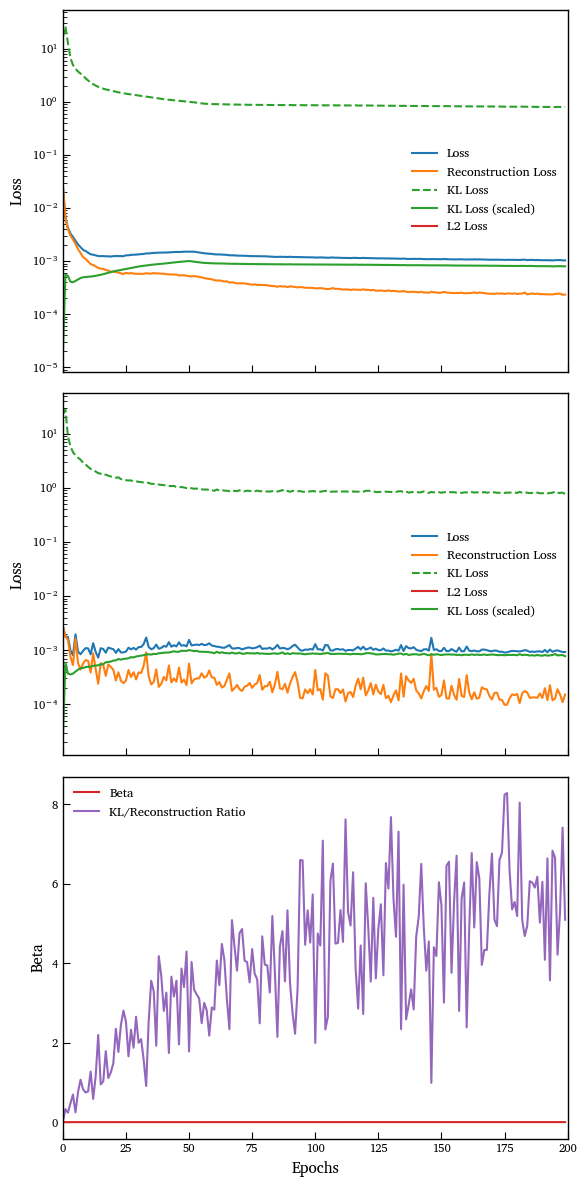

In [22]:
fig, axs = plt.subplots(3,1,figsize=(6, 12), sharex=True)

ax = axs[0]
ax.plot(model.train_losses['total'], 
         label='Loss', 
         color=plot_params.colors[0])
ax.plot(model.train_losses['reconstruction'],
         label='Reconstruction Loss', 
         color=plot_params.colors[1])
ax.plot(model.train_losses['kl'],
         label='KL Loss', 
         linestyle='--',
         color=plot_params.colors[2])
ax.plot(np.multiply(model.train_losses['kl'],model.val_losses['beta']),
         label='KL Loss (scaled)', 
         color=plot_params.colors[2])
ax.plot(model.train_losses['L2'],
         label='L2 Loss', 
         color=plot_params.colors[3])

ax.set_xlim([0,model.config['epochs']])
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()

ax = axs[1]
ax.plot(model.val_losses['total'], 
         label='Loss', 
         color=plot_params.colors[0])
ax.plot(model.val_losses['reconstruction'],
         label='Reconstruction Loss', 
         color=plot_params.colors[1])
ax.plot(model.val_losses['kl'],
         label='KL Loss', 
         linestyle='--',
         color=plot_params.colors[2])
ax.plot(model.val_losses['L2'],
         label='L2 Loss', 
         color=plot_params.colors[3])
ax.plot(np.multiply(model.val_losses['kl'],model.val_losses['beta']),
         label='KL Loss (scaled)', 
         color=plot_params.colors[2])
ax.set_xlim([0,model.config['epochs']])
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.legend()

ax = axs[2]
ax.plot(model.val_losses['beta'],
         label='Beta', 
         color=plot_params.colors[3])
ax.set_xlim([0,model.config['epochs']])
ax.set_xlabel('Epochs')
ax.set_ylabel('Beta')

ax.plot(np.array(model.val_losses['kl'])*model.val_losses['beta'] / np.array(model.val_losses['reconstruction']),
         label='KL/Reconstruction Ratio', 
         color=plot_params.colors[4])
ax.legend()

plt.tight_layout()
plt.show()

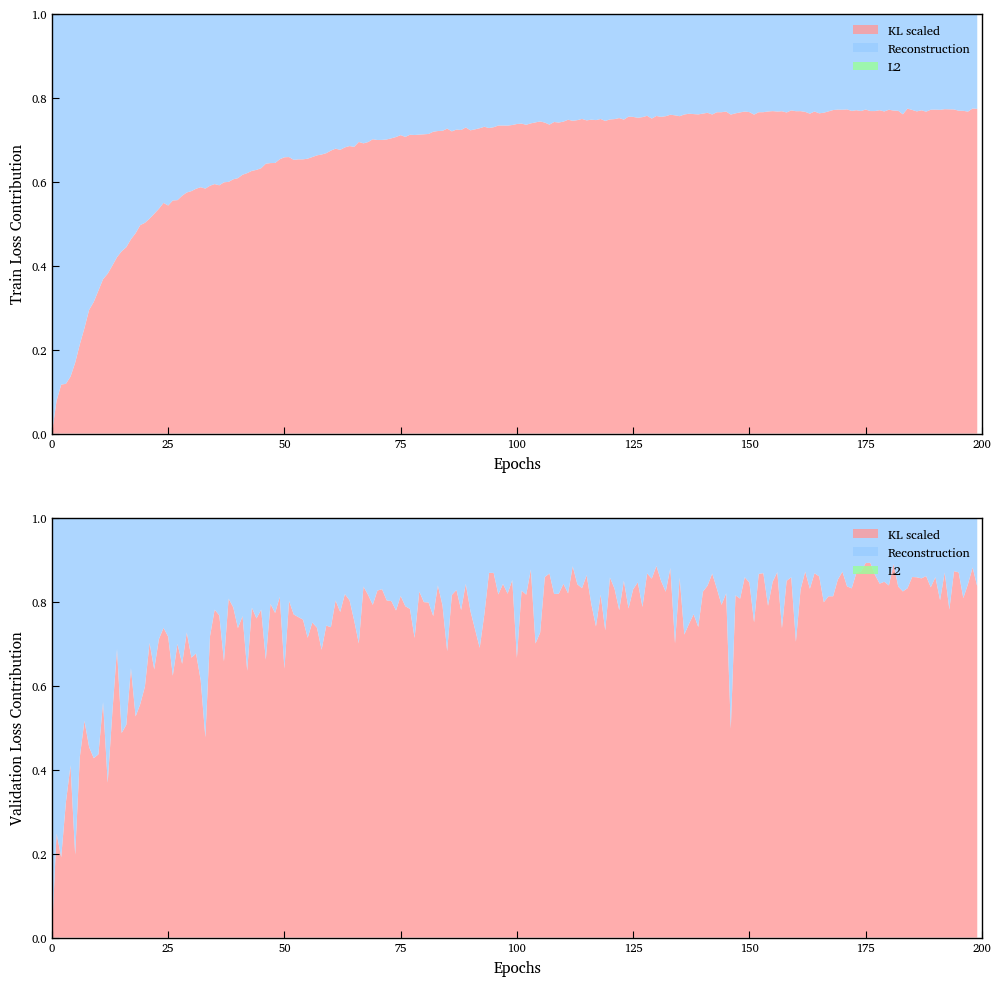

In [23]:
fig, axs = plt.subplots(2,1,figsize=(12, 12))

total_losses = np.array(model.train_losses['kl']) * np.array(model.val_losses['beta']) + np.array(model.train_losses['reconstruction']) + np.array(model.train_losses['L2'])

axs[0].stackplot(
    np.arange(len(total_losses)),
    np.array(model.train_losses['kl']) * np.array(model.val_losses['beta']) / total_losses, 
    np.array(model.train_losses['reconstruction']) / total_losses,
    np.array(model.train_losses['L2']) / total_losses,
    labels=['KL scaled', 'Reconstruction', 'L2'],
    colors=['#FF9999', '#99CCFF', '#99FF99'], # Light Red, Light Blue, Light Green
    alpha=0.8 # Transparency for better visual separation
)

total_losses = np.array(model.val_losses['kl']) * np.array(model.val_losses['beta']) + np.array(model.val_losses['reconstruction']) + np.array(model.val_losses['L2'])

axs[1].stackplot(
    np.arange(len(total_losses)),
    np.array(model.val_losses['kl']) * np.array(model.val_losses['beta']) / total_losses, 
    np.array(model.val_losses['reconstruction']) / total_losses,
    np.array(model.val_losses['L2']) / total_losses,
    labels=['KL scaled', 'Reconstruction', 'L2'],
    colors=['#FF9999', '#99CCFF', '#99FF99'], # Light Red, Light Blue, Light Green
    alpha=0.8 # Transparency for better visual separation
)

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Train Loss Contribution')
axs[0].set_xlim([0, model.config['epochs']])
axs[0].set_ylim(0,1)

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Validation Loss Contribution')
axs[1].set_xlim([0, model.config['epochs']])
axs[1].set_ylim(0,1)

axs[0].legend()
axs[1].legend()
plt.show()

### Latent Space Visualization

In [24]:
z, z_mean, labels = model.get_latent_space()

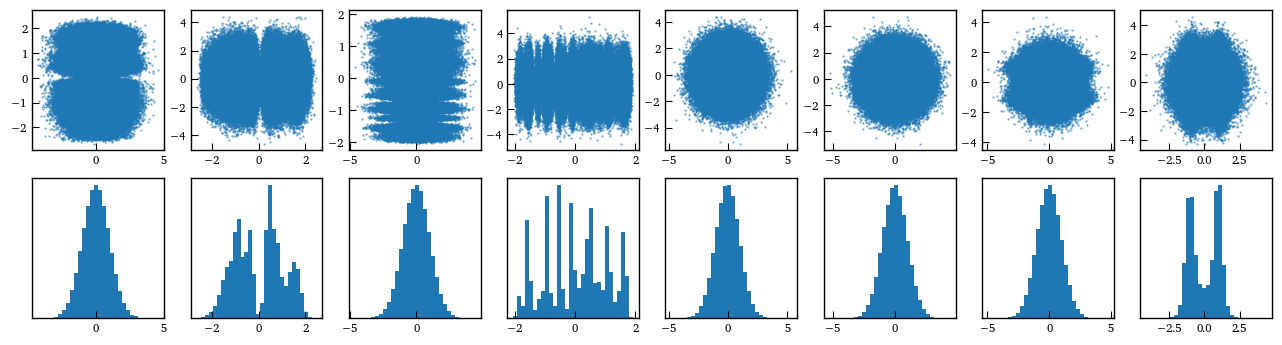

In [25]:
fig, axs = plt.subplots(2, model.config['latent_dim'], figsize=(2*model.config['latent_dim'], 4))

for i in range(model.config['latent_dim']):
    ax = axs[0,i]
    ax.scatter(z[:, i], z[:, (i+1)%model.config['latent_dim']],s=0.5,alpha=0.5)

for i in range(model.config['latent_dim']):
    ax = axs[1,i]
    ax.hist(z[:, i], bins=30)
    ax.set_yticks([])

In [26]:
def get_latent_space(model):
    x_tensor = torch.tensor(model.x_data, dtype=torch.float32)
    y_tensor = torch.tensor(model.y_data, dtype=torch.float32)

    z_mean, z_log_var = model.encoder(x_tensor, y_tensor)

    #z_mean, z_log_var = self.encoder(torch.tensor(self.x_data), torch.tensor(self.y_data))
    epsilon = torch.randn_like(z_mean)

    z = z_mean + torch.exp(0.5 * z_log_var) * epsilon
    z = z.detach().numpy()
    z_mean = z_mean.detach().numpy()

    labels = model.x_data[:,0]

    return z, z_mean, labels

In [27]:
for i in model.config["frozen_copies"]:
    model_copy = model.config["frozen_copies"][i]
    z, z_mean, labels = get_latent_space(model_copy)

    fig, axs = plt.subplots(1,2,figsize=(6,3))

    scatter_1 = axs[0].scatter(z[:, 0], z[:, 1], c=labels)
    axs[0].set_xlabel('z[0]')
    axs[0].set_ylabel('z[1]')

    scatter_2 = axs[1].scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    axs[1].set_xlabel('z_mean[0]')
    axs[1].set_ylabel('z_mean[1]')

    plt.suptitle(f"Epoch {i}")
    plt.tight_layout()
    plt.show()

### Check MVCs

#### Various MVCs

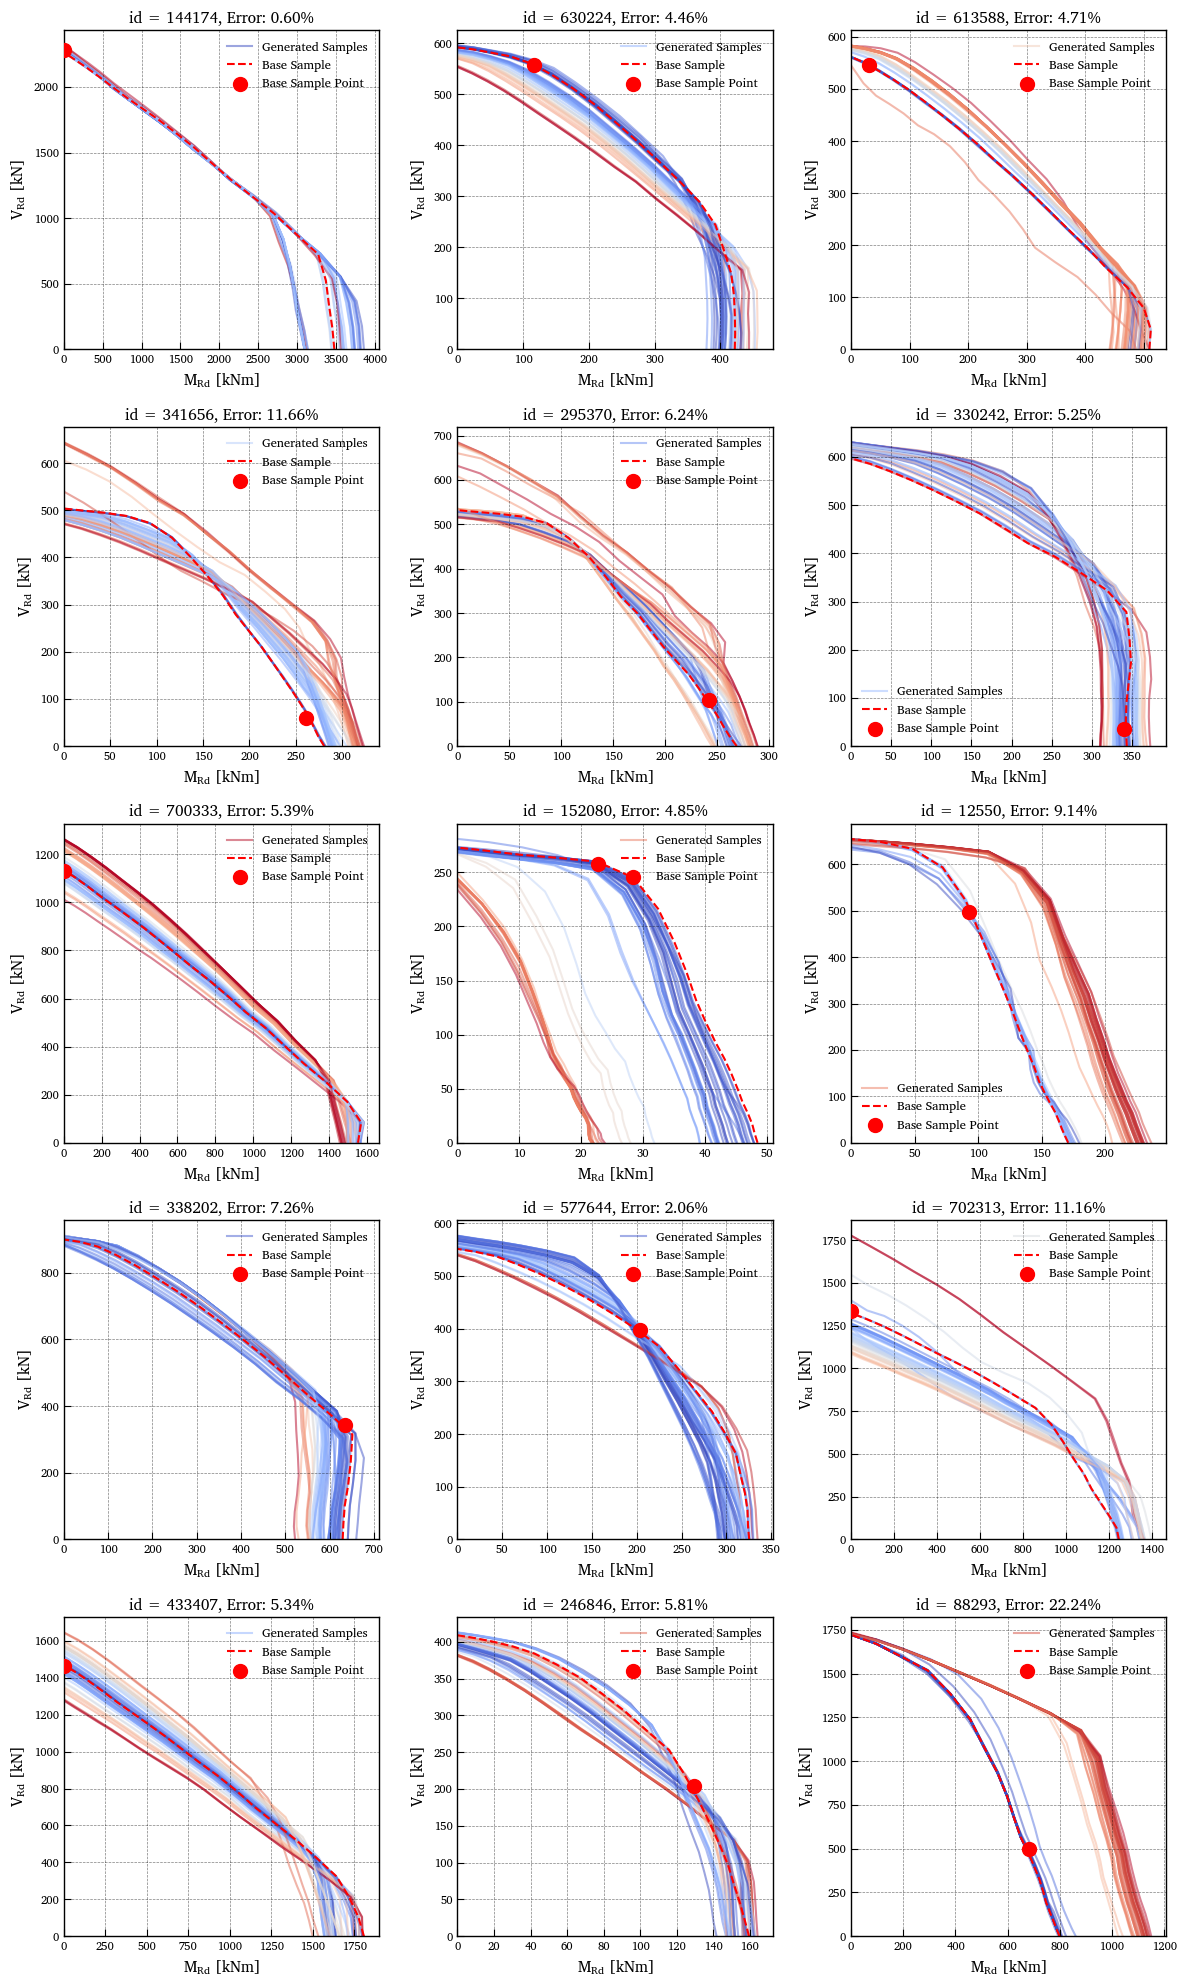

In [147]:
fig, axs = plt.subplots(5,3, figsize=(12, 20))

for i in range(5):
    for j in range(3):
        ax = axs[i,j]

        id = np.random.randint(0, len(df_full), 1)[0]
        base_sample = df_full.iloc[id:id+1].copy()
        n_samples = 50
        generated_samples = pd.concat([base_sample]*n_samples, ignore_index=True)

        #generated_features = sampling(model, base_sample, n_samples=n_samples, sample_distance_factor=1.0, sample_from='posterior')
        generated_features = model.sample(base_sample, n_samples=n_samples,sample_from='prior')
        generated_samples[features] = generated_features.values

        #generated_samples = clip(generated_samples, df, features)

        MRd_samples = np.zeros((n_samples, 20))
        VRd_samples = np.zeros((n_samples, 20))

        MRd_base, VRd_base, _ = model_forward.get_MV_interaction_prediction(base_sample.iloc[0],20)
        error = np.zeros(n_samples)

        for k,sample in generated_samples.iterrows():
            MRd_sample, VRd_sample, _ = model_forward.get_MV_interaction_prediction(sample,20)
            MRd_samples[k] = MRd_sample
            VRd_samples[k] = VRd_sample

            preds = np.array(list(zip(MRd_sample, VRd_sample)))
            true = np.array(list(zip(base_sample['M_Rd'], base_sample['V_Rd'])))
            orthogonal_distance = np.min(np.linalg.norm(preds - true, axis=1))
            error[k] = orthogonal_distance / np.linalg.norm(true)

        norm = mcolors.Normalize(vmin=np.min(error), vmax=np.max(error))
        cmap = plt.cm.coolwarm
        colors = cmap(norm(error))

        for k,(MRd, VRd) in enumerate(zip(MRd_samples, VRd_samples)):
            ax.plot(MRd, VRd, 
                    color=colors[k],                        
                    label=None if k > 0 else "Generated samples",
                    alpha=0.5,
                    zorder=0)

        ax.plot(MRd_base, VRd_base,
                    color='red',
                    linestyle='--',
                    alpha=1.0,
                    zorder=2,
                    label="Base sample")

        ax.scatter(base_sample['M_Rd'], base_sample['V_Rd'],
                    color='red',
                    marker='o',
                    s=100,
                    zorder=3,
                    label="Base sample point")

        ax.legend()
        ax.set_xlabel(plot_params.feature_labels['M_Rd'])
        ax.set_ylabel(plot_params.feature_labels['V_Rd'])
        ax.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)
        ax.set_title(f"id = {id}, Error: {np.mean(error)*100:.2f}%")

        ax.set_xlim([0,None])
        ax.set_ylim([0,None])

plt.tight_layout()
plt.show()

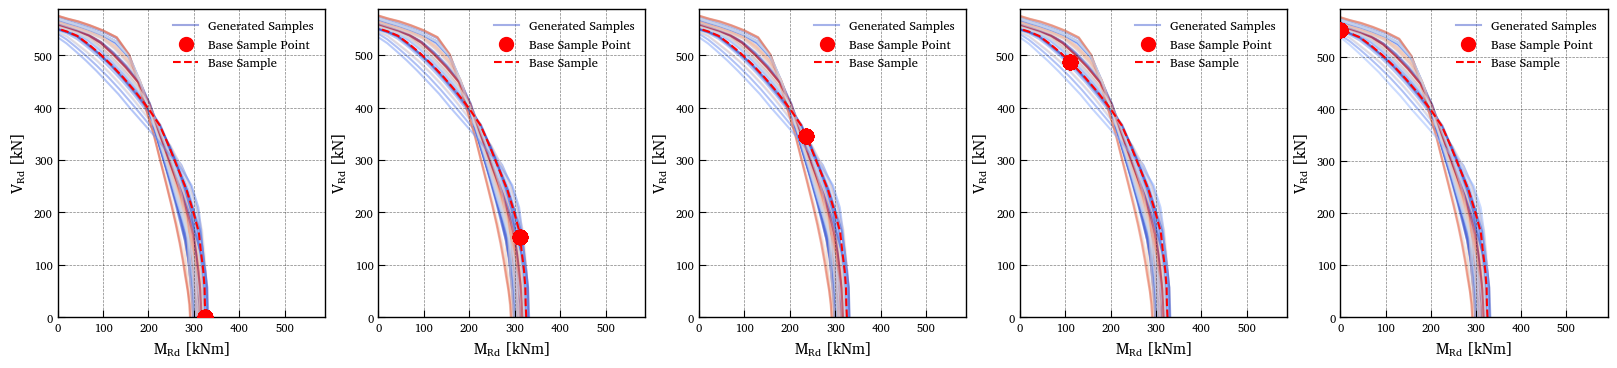

In [ ]:
n_loads = 5
fig, axs = plt.subplots(1,n_loads, figsize=(20, 4))

id = 577644
n_samples = 50

M_contribution = np.linspace(1, 0, n_loads)
V_contribution = np.linspace(0, 1, n_loads)

V_cont = V_contribution / np.sqrt(M_contribution**2 + V_contribution**2)
M_cont = M_contribution / np.sqrt(M_contribution**2 + V_contribution**2)

for i in range(n_loads):
    base_sample = df_full.iloc[id:id+1].copy()
    base_sample['M_contribution'] = M_cont[i]
    base_sample['V_contribution'] = V_cont[i]

    base_target, _ = model_forward.predict(base_sample)
    base_sample['M_Rd'] = base_target.numpy()[0][0] * base_sample['M_contribution'] * base_sample['Mpl_y']
    base_sample['V_Rd'] = base_target.numpy()[0][0] * base_sample['V_contribution'] * base_sample['Vpl_y']
    base_sample['M_norm'] = base_sample['M_Rd'] / base_sample['Mpl_y']
    base_sample['V_norm'] = base_sample['V_Rd'] / base_sample['Vpl_y']

    generated_samples = pd.concat([base_sample]*n_samples, ignore_index=True)

    #generated_features = sampling(model, base_sample, n_samples=n_samples, sample_distance_factor=1.0)
    generated_features = model.sample(base_sample, n_samples=n_samples,sample_from='prior')
    generated_samples[features] = generated_features.values

    MRd_samples = np.zeros((n_samples, 20))
    VRd_samples = np.zeros((n_samples, 20))

    MRd_base, VRd_base, _ = model_forward.get_MV_interaction_prediction(base_sample.iloc[0],20)
    error = np.zeros(n_samples)

    for k,sample in generated_samples.iterrows():
        MRd_sample, VRd_sample, _ = model_forward.get_MV_interaction_prediction(sample,20)
        MRd_samples[k] = MRd_sample
        VRd_samples[k] = VRd_sample

        preds = np.array(list(zip(MRd_sample, VRd_sample)))
        true = np.array(list(zip(MRd_base, VRd_base)))
        orthogonal_distance = np.min(np.linalg.norm(preds - true, axis=1))
        error[k] = orthogonal_distance / np.linalg.norm(true)

    norm = mcolors.Normalize(vmin=np.min(error), vmax=np.max(error))
    cmap = plt.cm.coolwarm
    colors = cmap(norm(error))

    ax = axs[i]

    for k,(MRd, VRd) in enumerate(zip(MRd_samples, VRd_samples)):
        ax.plot(MRd, VRd, 
                color=colors[k],                        
                label=None if k > 0 else "Generated Samples",
                alpha=0.5,
                zorder=0)
        
        ax.scatter(base_sample['M_Rd'], base_sample['V_Rd'],
                color='red',
                marker='o',
                s=100,
                zorder=3,
                label="Base Sample Point" if k == 0 else None)
        
        ax.set_xlim([0, max(max(MRd),max(VRd))*1.1])
        ax.set_ylim([0, max(max(MRd),max(VRd))*1.1])

    ax.plot(MRd_base, VRd_base,
                color='red',
                linestyle='--',
                alpha=1.0,
                zorder=2,
                label="Base Sample")

    ax.legend()
    ax.set_xlabel(plot_params.feature_labels['M_Rd'])
    ax.set_ylabel(plot_params.feature_labels['V_Rd'])
    ax.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

plt.show()

### Sampling

In [172]:
profile = df_full.iloc[577644:577644+1]
n_samples = 1000
profiles_sampled = model.sample(profile, n_samples, sample_distance_factor=1)

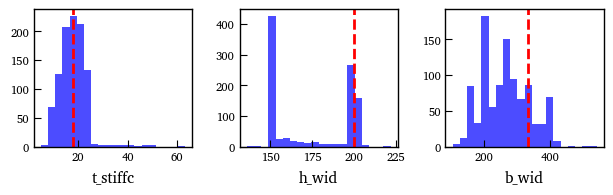

In [173]:
fig, axs = plt.subplots(1,3,figsize=plot_params.get_figsize(1.0,1/3))

for i, feature in enumerate(features):
    ax = axs[i]

    ax.hist(profiles_sampled[feature].values, 
            bins=20, color='blue', alpha=0.7, label='Sampled')
    ax.set_xlabel(feature)

    ax.axvline(profile[feature].values[0], 
            color='red', linestyle='--', lw=2.0,
            label='Original')

plt.tight_layout()
plt.show()

In [ ]:
categorical_threshold = 10_000

profiles_sampled_clipped = profiles_sampled.copy()

for feature in features:
    if feature in profiles_sampled.columns:
        if df_full[feature].nunique() < categorical_threshold:
            print(f"Feature {feature} is categorical with {df_full[feature].nunique()} unique values")

            valid_values = np.sort(df_full[feature].unique())

            def closest_value(x):
                idx = np.searchsorted(valid_values, x, side="left")
                if idx == 0:
                    return valid_values[0]
                if idx == len(valid_values):
                    return valid_values[-1]
                lower = valid_values[idx - 1]
                upper = valid_values[idx]
                return upper if abs(upper - x) < abs(lower - x) else lower

            profiles_sampled_clipped[feature] = profiles_sampled_clipped[feature].apply(closest_value)


Feature t_stiffc is categorical with 8 unique values
Feature h_wid is categorical with 87 unique values
Feature b_wid is categorical with 241 unique values


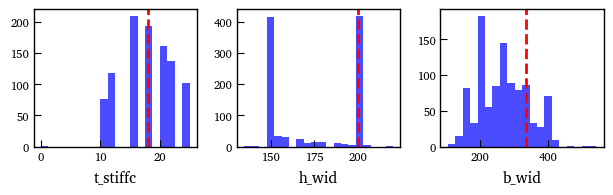

In [175]:
fig, axs = plt.subplots(1,3,figsize=plot_params.get_figsize(1.0,1/3))

for i, feature in enumerate(features):
    ax = axs[i]

    ax.hist(profiles_sampled_clipped[feature].values, 
            bins=20, color='blue', alpha=0.7, label='Sampled')
    ax.set_xlabel(feature)

    ax.axvline(profile[feature].values[0], 
            color='red', linestyle='--', lw=2.0,
            label='Original')

plt.tight_layout()
plt.show()

In [176]:
df_generated_profiles = pd.concat([profile]*n_samples, ignore_index=True)
df_generated_profiles[model.features] = profiles_sampled_clipped[model.features].values

df_profiles = pd.concat([profile, df_generated_profiles], ignore_index=True) # with base profile

### Check feasibilty of sampled data

#### Define relevant functions

Load feasible Hypercubemap

In [177]:
hypercubemap = np.load(r"Saved Variables\hypercubemap.npy")

Categroizes data into bins, according to each dimension (=feature)

In [178]:
def find_bins(datapoint, bounds, m):
    bin_widths = (bounds[:, 1] - bounds[:, 0]) / m
    if np.any(datapoint < bounds[:, 0]) or np.any(datapoint > bounds[:, 1]):
        return None

    bin_indices = np.zeros(len(datapoint), dtype=int)
    nonzero_mask = bin_widths > 0

    bin_indices[nonzero_mask] = ((datapoint[nonzero_mask] - bounds[nonzero_mask][:, 0]) / (bin_widths[nonzero_mask])).astype(int)
    bin_indices[nonzero_mask] = np.clip(bin_indices[nonzero_mask], 0, m - 1)
    
    return tuple(bin_indices)

Calculates maximum and average feasibilty.

In [179]:
def check_feasibility(datapoint, hypercubemap, bounds, m):
    bin_indices = find_bins(datapoint, bounds, m)

    if bin_indices is None:
        return 'Datapoint is out of bounds'
    
    closest_index = np.argmin(np.sum((hypercubemap - bin_indices) ** 2, axis=1))
    closest_bin = hypercubemap[closest_index]
    error = np.abs(closest_bin - bin_indices)

    feasibilty_degree = np.max(error)

    return feasibilty_degree, np.sum(error)/len(error)

In [180]:
with open("Saved Variables\hypercube_features.json", "rb") as file: 
       hypercube_features = pickle.load(file)

Upper and lower bounds of each dimension

In [181]:
bounds = np.array([df_full[hypercube_features].min(), df_full[hypercube_features].max()]).T

#### Check Feasibility

In [182]:
datapoint = df_generated_profiles[hypercube_features].iloc[np.random.randint(0, df_generated_profiles.shape[0])].values
m = int(np.max(hypercubemap))

bin_widths = (bounds[:, 1] - bounds[:, 0]) / m

bin_indices = ((datapoint - bounds[:, 0]) / bin_widths).astype(int)
bin_indices = np.clip(bin_indices, 0, m - 1)

Calculate *Feasibility Degree*:
1. Find closest feasible hypercube to sample (given sample is infeasible and is not in the hypercubemap)
2. For each dimensions obtain the number of steps (bins) required to move to the closest feasible hypercube
3. The maximum number of steps over all dimensions is the *Feasibility Degree*

In [183]:
diff = hypercubemap - bin_indices
diff = diff ** 2
diff = np.sum(diff, axis=1)
closest_index = np.argmin(diff)
closest_bin = hypercubemap[closest_index]
feasibility_degree = np.abs(closest_bin - bin_indices)

print(closest_bin)
print(bin_indices)
print(abs(closest_bin - bin_indices))

[1. 6. 3. 3. 2. 1. 0. 0. 0. 1. 1. 0. 0. 1. 6. 3. 3. 2. 1. 0. 0. 0. 1. 1.
 0. 0. 2. 3. 1. 1. 6. 5. 4. 4.]
[1 6 3 3 2 1 0 0 0 1 1 0 0 1 6 3 3 2 1 0 0 0 1 1 0 0 2 4 1 1 6 5 3 4]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]


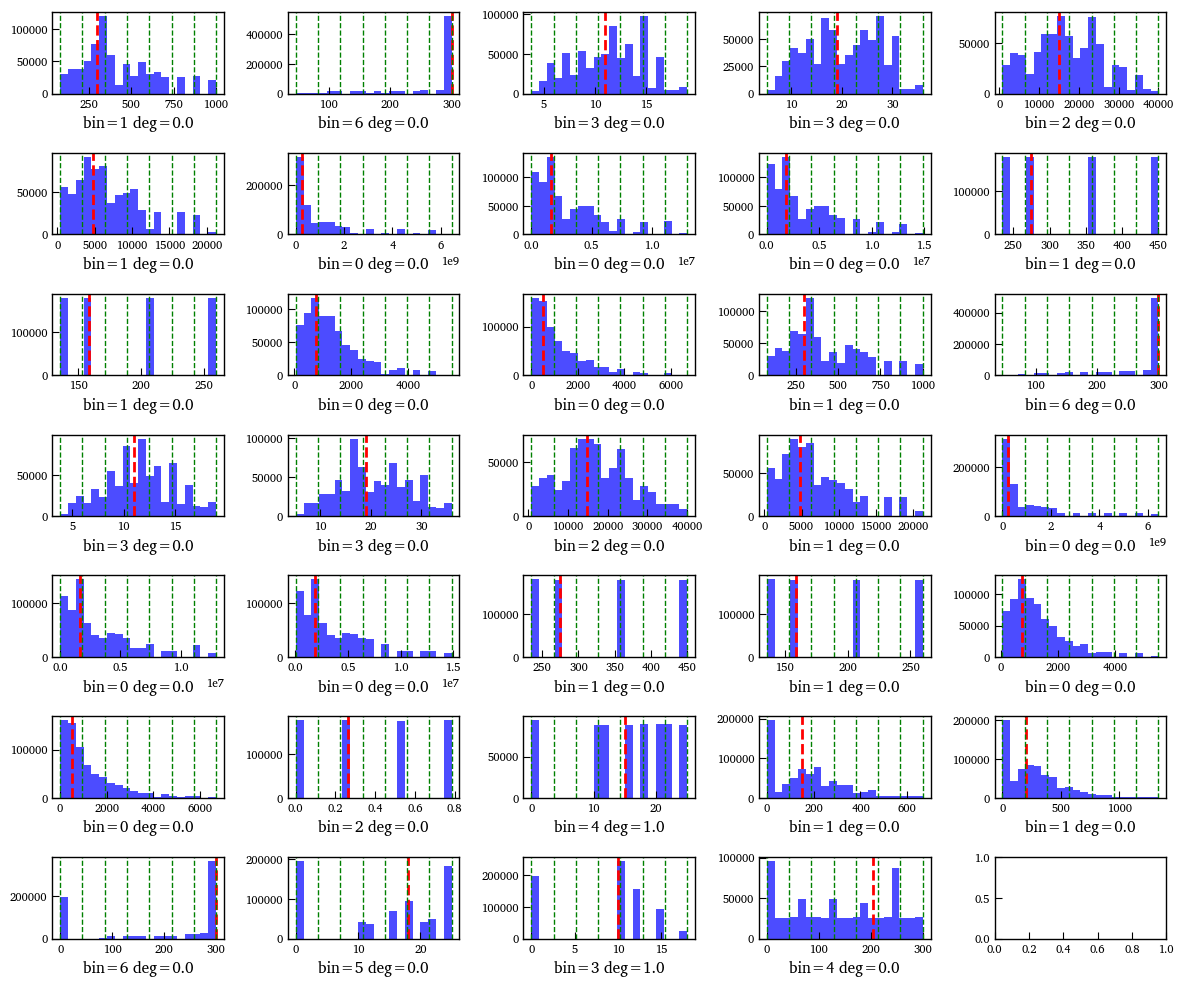

In [184]:
fig, axs = plt.subplots(len(hypercube_features)//5+1,5,figsize=(12, 10))

for i, feature in enumerate(hypercube_features):
    ax = axs[i//5, i%5]

    ax.hist(df_full[feature].values, 
            bins=20, color='blue', alpha=0.7, label='Sampled')
    ax.set_xlabel(f"bin={bin_indices[i]} deg={feasibility_degree[i]}")

    ax.axvline(datapoint[i], 
            color='red', linestyle='--', lw=2.0,
            label='Original')
    
    for j in range(m+1):
        ax.axvline(bounds[i, 0] + j * bin_widths[i], 
                color='green', linestyle='--', lw=1.0)

plt.tight_layout()
plt.show()

In [185]:
check_feasibility(datapoint, hypercubemap, bounds, m)

(1.0, 0.058823529411764705)

For each sample calculate the *Feasibility Degree* and the *Average Infeasibility*. 

Calculation of the *Average Infeasibility*:
1. Find the closest feasible hypercube to the sample (given that the sample is infeasible and not in the hypercubemap)
2. Calculate the euclidian distance between the sample and the closest feasible hypercube in the hyperdimensional space

In [186]:
feasibility_degrees = []
average_infeasibilties = []

for i,row in df_generated_profiles.iterrows():
    datapoint = row[hypercube_features].values
    if np.any(np.isnan(datapoint.astype(float))):
        print(f"Skipping row {i} due to NaN or Inf values")
        continue
    feasibility_degree, average_infeasibilty = check_feasibility(datapoint, hypercubemap, bounds, m)
    average_infeasibilties.append(average_infeasibilty)
    feasibility_degrees.append(feasibility_degree)

In [187]:
feasibility_degree = np.array(feasibility_degrees)
average_infeasibilties = np.array(average_infeasibilties)

df_generated_profiles['feasibility_degree'] = feasibility_degree
df_generated_profiles['average_infeasibility'] = average_infeasibilties

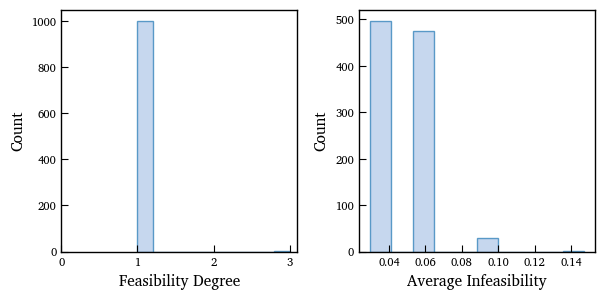

In [188]:
fig, axs = plt.subplots(1,2,figsize=plot_params.get_figsize(1.0,1/2))

ax = axs[0]
ax.hist(feasibility_degrees,
         facecolor=plot_params.morecolors[1],
         edgecolor=plot_params.morecolors[0], 
         alpha=0.7)

ax.set_xticks(np.arange(0, max(feasibility_degree)+1, 1))

ax.set_xlabel('Feasibility Degree')
ax.set_ylabel('Count')

ax = axs[1]
ax.hist(average_infeasibilties,
         facecolor=plot_params.morecolors[1],
         edgecolor=plot_params.morecolors[0], 
         alpha=0.7)

ax.set_xlabel('Average Infeasibility')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

### MV Interaction of Samples

Get target prediction from samples:

In [189]:
target_preds, _ = model_forward.predict(df_generated_profiles)
target_preds = target_preds.numpy().flatten()
df_generated_profiles['target'] = target_preds

Get load capacities for samples with calculated targets:

In [190]:
Mpl_y = df_generated_profiles['Mpl_y'].values
Vpl_y = df_generated_profiles['Vpl_y'].values

M_cont = df_generated_profiles['M_contribution'].values
V_cont = df_generated_profiles['V_contribution'].values

M_Rd_pred = target_preds * Mpl_y * M_cont
V_Rd_pred = target_preds * Vpl_y * V_cont

M_Rd_cond = profile['M_Rd'].values
V_Rd_cond = profile['V_Rd'].values

Get uncertainties for samples:

In [191]:
mcd_mean, mcd_std, mcd_preds_profile = model_forward.mc_dropout_uncertainty(df_profiles,num_samples=500)
uncertainty = mcd_std / mcd_mean

df_generated_profiles['M_Rd_pred'] = M_Rd_pred
df_generated_profiles['V_Rd_pred'] = V_Rd_pred
df_generated_profiles['uncertainty'] = uncertainty[1:]

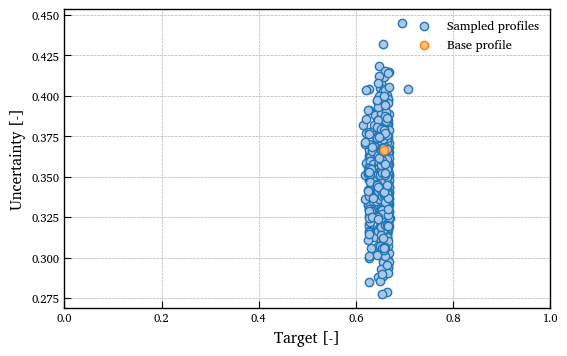

In [192]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(1.0))

plt.scatter(df_generated_profiles['target'], 
            df_generated_profiles['uncertainty'], 
            facecolor=plot_params.morecolors[1],
            edgecolor=plot_params.morecolors[0],
            label='Sampled profiles',
            zorder=2,
            )

plt.scatter(profile['target'],
            uncertainty[0], 
            facecolor=plot_params.morecolors[3],
            edgecolor=plot_params.morecolors[2],
            label='Base profile',
            zorder=2
            )

plt.legend()
plt.xlabel('Target [-]')
plt.ylabel('Uncertainty [-]')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)

plt.xlim([0,1])

plt.show()

In [193]:
fixed_features = model_forward.features.copy()
fixed_features.remove('M_contribution')
fixed_features.remove('V_contribution')

### Calculate Wonkyness (=Wobbliness)

Some MV interaction predictions have a wonky outline, indicating uncertainty in the model prediction. Calculate the *wonkyness* as a metric.

In [194]:
def calculate_wonkyness(x_coords, y_coords):
    angles = []
    for i in range(len(x_coords) - 2):
        # Define the three consecutive points
        p1 = np.array([x_coords[i], y_coords[i]])
        p2 = np.array([x_coords[i+1], y_coords[i+1]])
        p3 = np.array([x_coords[i+2], y_coords[i+2]])

        # Vector of the first segment (p2 - p1)
        v1 = p2 - p1
        # Vector of the second segment (p3 - p2)
        v2 = p3 - p2

        # Calculate the angle between the two vectors using the dot product
        dot_product = np.dot(v1, v2)
        magn_v1 = np.linalg.norm(v1)
        magn_v2 = np.linalg.norm(v2)

        cos_theta = dot_product / (magn_v1 * magn_v2)
        # Ensure cos_theta is within the valid range [-1, 1] due to potential floating-point errors
        cos_theta = np.clip(cos_theta, -1.0, 1.0)
        angle = np.arccos(cos_theta)

        angles.append(angle)

    return np.std(angles)

In [195]:
n_predictions = 20

interaction_profiles = {'M_Rd_pred': [], 'V_Rd_pred': [], 'wonkyness': []}

for i,x_profile in df_generated_profiles.iterrows():

    M_Rd_pred, V_Rd_pred, targets_predicted = model_forward.get_MV_interaction_prediction(x_profile,n_predictions=n_predictions)

    wonkyness = calculate_wonkyness(M_Rd_pred, V_Rd_pred)

    interaction_profiles['M_Rd_pred'].append(M_Rd_pred)
    interaction_profiles['V_Rd_pred'].append(V_Rd_pred)
    interaction_profiles['wonkyness'].append(wonkyness)

In [196]:
df_generated_profiles['wonkyness'] = interaction_profiles['wonkyness']

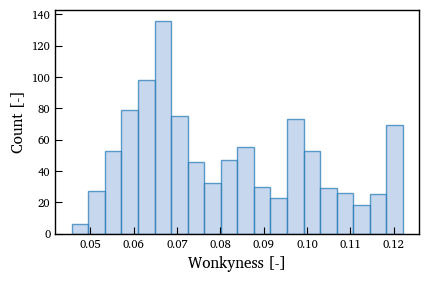

In [197]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))
plt.hist(df_generated_profiles['wonkyness'], 
         bins=20, 
         facecolor=plot_params.morecolors[1],
         edgecolor=plot_params.morecolors[0], 
         alpha=0.7)

plt.xlabel('Wonkyness [-]')
plt.ylabel('Count [-]')
plt.show()

### Plot MVC of samples

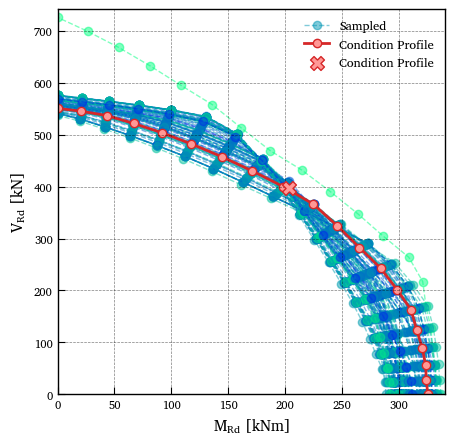

In [198]:
n_predictions = 20
plot_n = 100

fig, ax = plt.subplots(figsize=(5, 5))

for i,(M_Rd_pred,V_Rd_pred) in enumerate(zip(interaction_profiles['M_Rd_pred'][:plot_n], interaction_profiles['V_Rd_pred'][:plot_n])):

    norm = mcolors.Normalize(vmin=min(df_generated_profiles['uncertainty'][:plot_n]), vmax=max(df_generated_profiles['uncertainty'][:plot_n]))
    cmap = plt.cm.winter 
    color = cmap(norm(df_generated_profiles['uncertainty'][i]))

    label = "Sampled" if i == 0 else None

    plt.plot(M_Rd_pred, V_Rd_pred,
             marker='o',
             color=color,
             linewidth=1.0,
             linestyle='--',
             alpha=0.5,
             zorder=0,
             label=label)

    plt.xlabel(plot_params.feature_labels['M_Rd'])
    plt.ylabel(plot_params.feature_labels['V_Rd'])
    plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.xlim([0,None])
    plt.ylim([0,None])

M_Rd_condition, V_Rd_condition, _ = model_forward.get_MV_interaction_prediction(profile, n_predictions=n_predictions)

plt.plot(M_Rd_condition, V_Rd_condition,
         marker='o',
         color=plot_params.morecolors[6],
         markerfacecolor=plot_params.morecolors[7],
         markeredgecolor=plot_params.morecolors[6],
         linestyle='-',
         linewidth=2.0,
         label="Condition Profile",
         zorder=1)

plt.scatter(M_Rd_cond, V_Rd_cond, 
            s=100, 
            marker='X',
            color=plot_params.morecolors[7], 
            edgecolors=plot_params.morecolors[6], 
            linewidth=1.0,                        
            label="Condition Profile",
            zorder=3)

plt.xlim([0,np.max(np.array(interaction_profiles['M_Rd_pred']))])
plt.ylim([0,np.max(np.array(interaction_profiles['V_Rd_pred']))])

plt.legend()
plt.show()

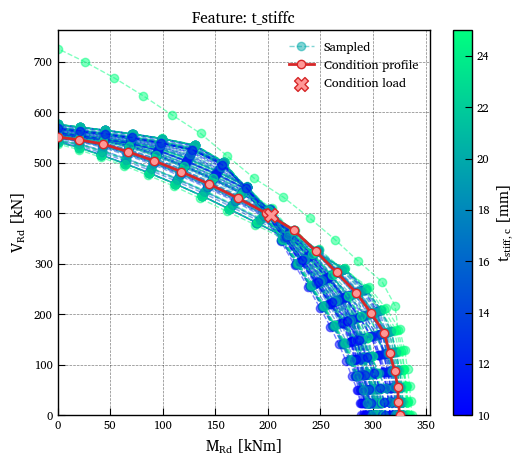

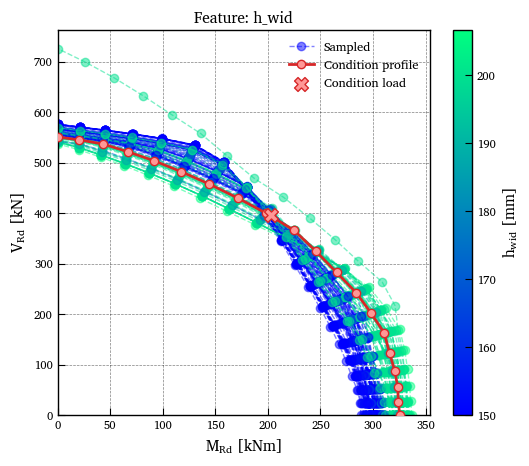

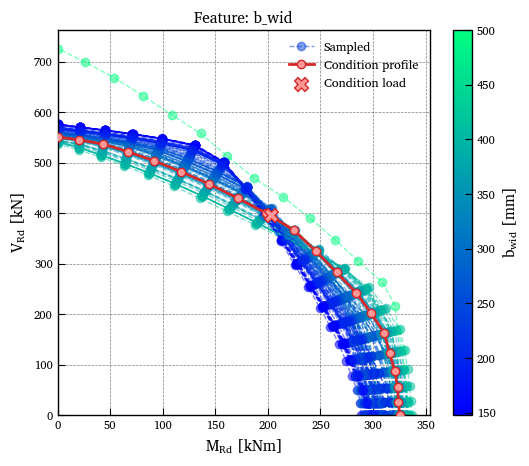

In [208]:
features_to_compare = features

for i, feature in enumerate(features_to_compare):
    fig, ax = plt.subplots(figsize=(6, 5))

    color_data = df_generated_profiles[feature].values
    norm = mcolors.Normalize(vmin=min(color_data[:plot_n]), vmax=max(color_data[:plot_n]))
    cmap = plt.cm.winter
    colors = cmap(norm(color_data[:plot_n]))

    M_Rd_pred_list = interaction_profiles['M_Rd_pred'][:plot_n]
    V_Rd_pred_list = interaction_profiles['V_Rd_pred'][:plot_n]

    for i, (M_Rd_pred, V_Rd_pred, uncertainty) in enumerate(zip(M_Rd_pred_list, V_Rd_pred_list, df_generated_profiles['uncertainty'][:plot_n])):
        label = "Sampled" if i == 0 else None
        plt.plot(M_Rd_pred, V_Rd_pred,
                 color=colors[i],
                 marker='o',
                 linewidth=1.0,
                 linestyle='--',
                 alpha=0.5,
                 label=label,
                 zorder=2)

    M_Rd_condition, V_Rd_condition, _ = model_forward.get_MV_interaction_prediction(profile, n_predictions=n_predictions)

    plt.plot(M_Rd_condition, V_Rd_condition,
             marker='o',
             color=plot_params.morecolors[6],
             markerfacecolor=plot_params.morecolors[7],
             markeredgecolor=plot_params.morecolors[6],
             linestyle='-',
             linewidth=2.0,
             label="Condition profile",
             zorder=3)
    
    plt.scatter(M_Rd_cond, V_Rd_cond,
                s=100,
                marker='X',
                color=plot_params.morecolors[7],
                edgecolors=plot_params.morecolors[6],
                linewidth=1.0,
                label="Condition load",
                zorder=4)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label(plot_params.feature_labels[feature])

    plt.title(f"Feature: {feature}")
    plt.xlabel(plot_params.feature_labels['M_Rd'])
    plt.ylabel(plot_params.feature_labels['V_Rd'])
    plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
    plt.xlim([0, None])
    plt.ylim([0, None])
    plt.legend()
    plt.show()


### Interaction Curve Classification

n clusters have been build on the whole dataset, categorizing each MV interaction outline, based on similarities in shape (not absolute values). Used the learned cluster algorithm to classify the sampled profiles from the CVAE.

#### Load PCA and KMEANS

In [209]:
with open(r"Saved Variables\interaction_pca.pkl", "rb") as file:
    pca = pickle.load(file)

with open(r"Saved Variables\interaction_kmeans.pkl", "rb") as file:
    kmeans = pickle.load(file)

#### Cluster Functions

In [210]:
def normalize_curve(points):
    points = np.array(points)
    max_val = np.max(points) #max_vals = np.max(points, axis=0) (Both axes fixed on (1,0), (1,0)
    return points / max_val

def resample_curve(points, num_points=100):
    points = np.array(points)
    dist = np.cumsum(np.sqrt(np.sum(np.diff(points, axis=0)**2, axis=1)))
    dist = np.insert(dist, 0, 0)
    uniform_dist = np.linspace(0, dist[-1], num_points)
    interp_func = interp1d(dist, points, axis=0)
    return interp_func(uniform_dist)

def flatten_curve(points):
    return points.flatten()

def preprocess_curves(curves, num_points=100):
    return [flatten_curve(resample_curve(normalize_curve(c), num_points)) for c in curves]

In [211]:
def assign_new_data_to_clusters(new_curves, pca, kmeans):
    new_data = preprocess_curves(new_curves)
    reduced_new_data = pca.transform(new_data)
    cluster_labels = kmeans.predict(reduced_new_data)
    distances = np.min(kmeans.transform(reduced_new_data), axis=1)
    silhouette_avg = silhouette_score(reduced_new_data, cluster_labels)
    
    return cluster_labels, distances, silhouette_avg

#### Fit Curves to Clusters

In [212]:
interaction_curves = np.array(list(zip(interaction_profiles['M_Rd_pred'],
                                      interaction_profiles['V_Rd_pred'])))
interaction_curves = np.transpose(interaction_curves, (0, 2, 1))

In [213]:
interactions_processed = np.array(preprocess_curves(interaction_curves))
interactions_reduced = pca.transform(interactions_processed)
interactions_labels = kmeans.predict(interactions_reduced)
interactions_distances = kmeans.transform(interactions_reduced)
interactions_label_distances = np.min(interactions_distances, axis=1)
interactions_silhouette_avg = silhouette_score(interactions_reduced, interactions_labels)

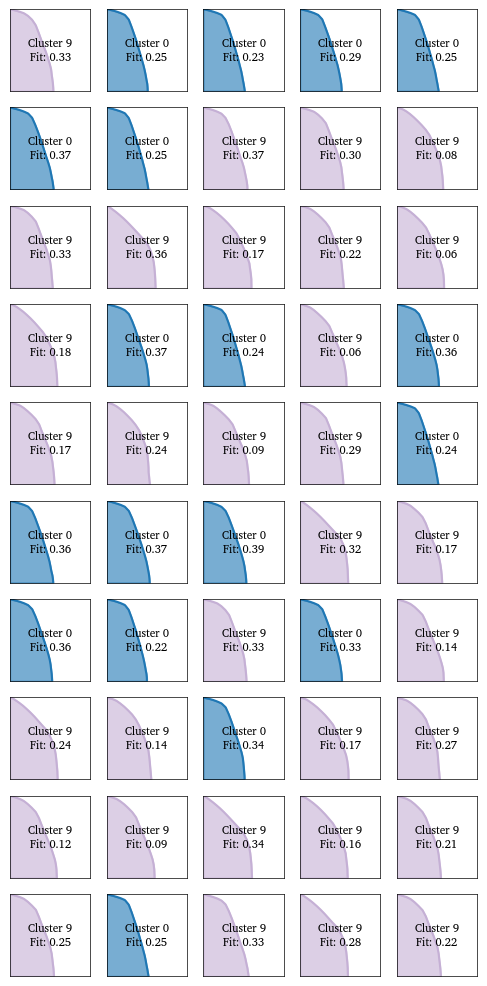

In [214]:
plot_n = 50

fig, axs = plt.subplots(plot_n//5, 5, figsize=(5, plot_n//5), sharex=True, sharey=True)

for i,interaction in enumerate(interactions_processed[:plot_n]):
    ax = axs[i//5, i%5]
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    x = interaction[::2]
    y = interaction[1::2]
    color = plot_params.morecolors[interactions_labels[i]]

    ax.plot(x, y, color=color, linewidth=1.5)
    ax.fill_between(x, 0, y, color=color, alpha=0.6)

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    ax.annotate(f"Cluster {interactions_labels[i]}\nFit: {interactions_label_distances[i]:.2f}", xy=(0.5, 0.5), 
                xycoords='axes fraction', ha='center', va='center', fontsize=8)


plt.tight_layout()
plt.show()

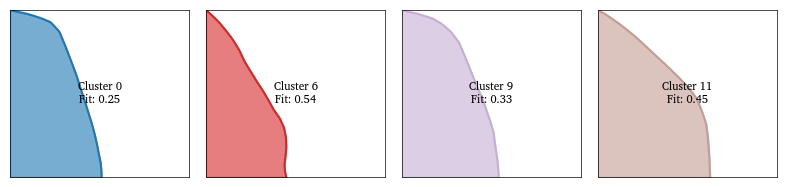

In [215]:
labels_unique_ids = [np.where(interactions_labels == label)[0][0] for label in np.unique(interactions_labels)]

fig, axs = plt.subplots(1, len(labels_unique_ids), figsize=(2*len(labels_unique_ids),2), sharex=True, sharey=True)

for i, id in enumerate(labels_unique_ids):
    ax = axs[i]
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

    interaction = interactions_processed[id]

    x = interaction[::2]
    y = interaction[1::2]
    color = plot_params.morecolors[interactions_labels[id]]

    ax.plot(x, y, color=color, linewidth=1.5)
    ax.fill_between(x, 0, y, color=color, alpha=0.6)

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

    ax.annotate(f"Cluster {interactions_labels[id]}\nFit: {interactions_label_distances[id]:.2f}", xy=(0.5, 0.5),
                xycoords='axes fraction', ha='center', va='center', fontsize=8)


plt.tight_layout()
plt.show()

#### Analysis

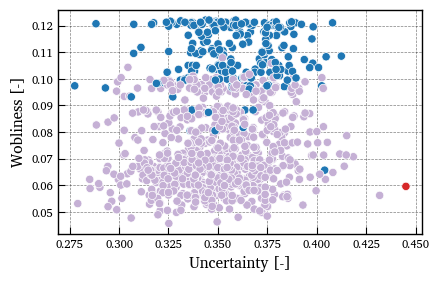

In [231]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

colors = [plot_params.morecolors[i] for i in interactions_labels]

plt.scatter(df_generated_profiles['uncertainty'],
            interaction_profiles['wonkyness'],
            facecolor=colors,
            edgecolors='white',
            linewidth=0.5,
            zorder=2)

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.xlabel('Uncertainty [-]')
plt.ylabel('Wobliness [-]')

plt.show()

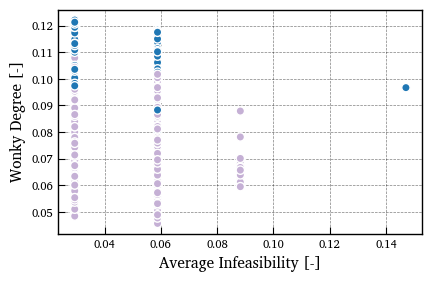

In [232]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

plt.scatter(df_generated_profiles['average_infeasibility'],
            interaction_profiles['wonkyness'],
            facecolor=colors,
            edgecolors='white',
            zorder=2)

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.xlabel('Average Infeasibility [-]')
plt.ylabel('Wonky Degree [-]')

plt.show()

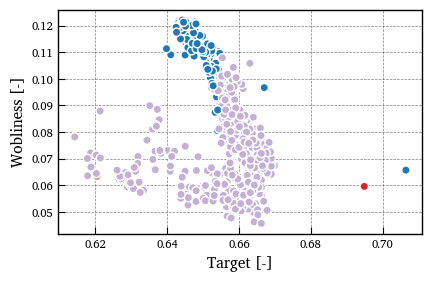

In [233]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

plt.scatter(df_generated_profiles['target'],
            interaction_profiles['wonkyness'],
            facecolor=colors,
            edgecolors='white',
            zorder=2)

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.xlabel('Target [-]')
plt.ylabel('Wobliness [-]')

plt.show()

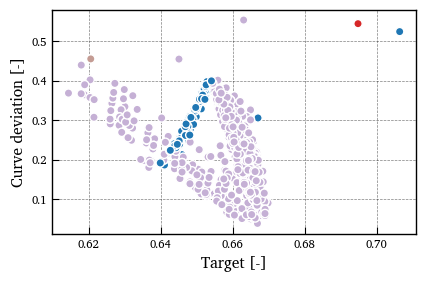

In [234]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

plt.scatter(df_generated_profiles['target'],
            interactions_label_distances,
            facecolor=colors,
            edgecolors='white',
            zorder=2)

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.xlabel('Target [-]')
plt.ylabel('Curve deviation [-]')

plt.show()

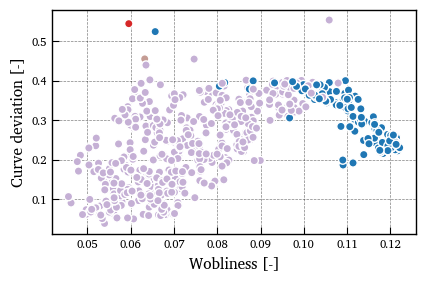

In [235]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

plt.scatter(interaction_profiles['wonkyness'],
            interactions_label_distances,
            facecolor=colors,
            edgecolors='white',
            zorder=2)

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.xlabel('Wobliness [-]')
plt.ylabel('Curve deviation [-]')

plt.show()

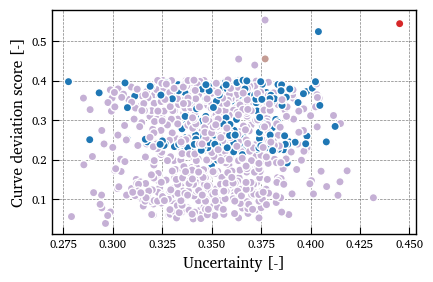

In [241]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

plt.scatter(df_generated_profiles['uncertainty'],
            interactions_label_distances,
            facecolor=colors,
            edgecolors='white',
            zorder=2)

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.xlabel('Uncertainty [-]')
plt.ylabel('Curve deviation score [-]')

plt.show()

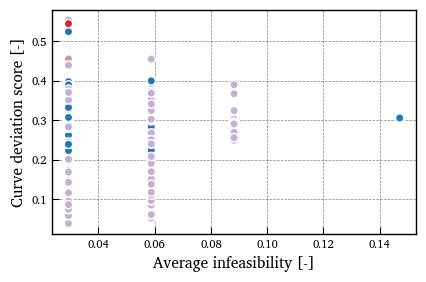

In [237]:
fig, ax = plt.subplots(figsize=plot_params.get_figsize(0.75))

plt.scatter(df_generated_profiles['average_infeasibility'],
            interactions_label_distances,
            facecolor=colors,
            edgecolors='white',
             zorder=2)

plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)
plt.ylabel('Curve deviation score [-]')
plt.xlabel('Average infeasibility [-]')

plt.show()

### Analyse all metrics

### Filter

Based on the introdced metrics (uncertainty, wonkyness, infeasibilty, curve deviation) filter the sampled profiles. Introduce a threshold, either absolute or relative, to serve as a cutoff for *bad* samples. Use boolean logic to combine the filters to obtain a final mask.

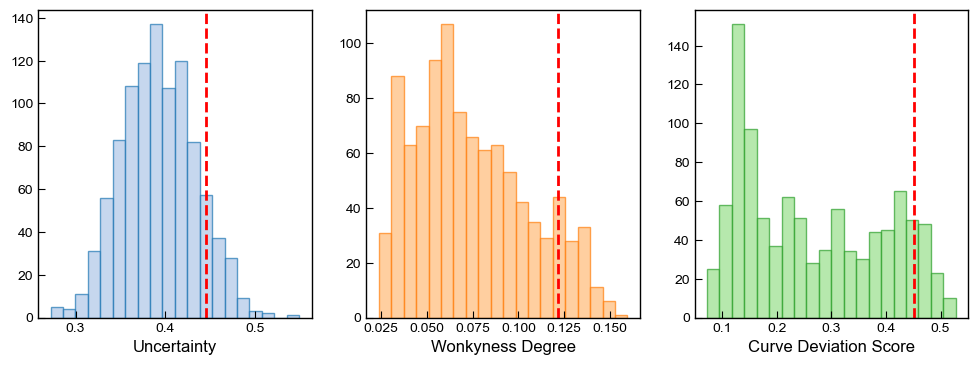

In [94]:
fig, axs = plt.subplots(1,3,figsize=(12, 4))

alpha = 90

ax = axs[0]
threshold = np.percentile(df_generated_profiles['uncertainty'].values, alpha)
mask_uncertainty = df_generated_profiles['uncertainty'].values < threshold
ax.hist(df_generated_profiles['uncertainty'].values,
         bins=20, 
         facecolor=plot_params.morecolors[1],
         edgecolor=plot_params.morecolors[0],
         alpha=0.7)
ax.set_xlabel('Uncertainty')
ax.axvline(threshold, color='red', linestyle='--', lw=2.0, label='Threshold')

ax = axs[1]
threshold = np.percentile(interaction_profiles['wonkyness'], alpha)
mask_wonkyness = interaction_profiles['wonkyness'] < threshold
ax.hist(interaction_profiles['wonkyness'],
         bins=20, 
         facecolor=plot_params.morecolors[3],
         edgecolor=plot_params.morecolors[2],
         alpha=0.7)
ax.set_xlabel('Wonkyness Degree')
ax.axvline(threshold, color='red', linestyle='--', lw=2.0, label='Threshold')

ax = axs[2]
threshold = np.percentile(interactions_label_distances, alpha)
mask_label_distances = interactions_label_distances < threshold
ax.hist(interactions_label_distances,
         bins=20, 
         facecolor=plot_params.morecolors[5],
         edgecolor=plot_params.morecolors[4],
         alpha=0.7)
ax.set_xlabel('Curve Deviation Score')
ax.axvline(threshold, color='red', linestyle='--', lw=2.0, label='Threshold')

plt.show()

In [95]:
combined_mask = np.all([mask_uncertainty, mask_wonkyness, mask_label_distances], axis=0)

In [96]:
np.count_nonzero(combined_mask)

749

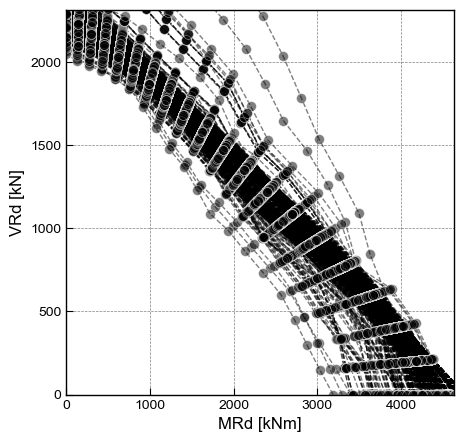

In [97]:
n_predictions = 20

fig, ax = plt.subplots(figsize=(5, 5))

interactions_filtered_M_Rd = np.array(interaction_profiles['M_Rd_pred'])[combined_mask]
interactions_filtered_V_Rd = np.array(interaction_profiles['V_Rd_pred'])[combined_mask]

for i,(M_Rd_pred,V_Rd_pred) in enumerate(zip(interactions_filtered_M_Rd, interactions_filtered_V_Rd)):

    plt.scatter(M_Rd_pred, V_Rd_pred, 
                s=50, 
                facecolor='black',
                edgecolors='white', 
                linewidth=0.5,                        
                label="Predicted",
                alpha=0.5,
                zorder=2)

    plt.plot(M_Rd_pred, V_Rd_pred,
                color='black',
                linewidth=1.0,
                linestyle='--',
                alpha=0.5,
                zorder=0)

    plt.xlabel("MRd [kNm]")
    plt.ylabel("VRd [kN]")
    plt.grid(True, which='major', color='k', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.xlim([0,None])
    plt.ylim([0,None])

plt.show()